# *Welcome!*
This is a notebook collecting, organizing, and analyzing the structural measurements (primarily dip angles, directions, and interlimb angles) along anticlines of Tuscarora formation beds in West Virginia, Virginia, Pennsylvania, and Maryland. For a briefer than brief explanation, the structural components of these anticlines are being interpreted and used as control against hypotheses on climate-based hillslope curvature. My purpose is to demonstrate the changes in structure along latitudes (~36-41) of the Appalachias from a set number of points we've chosen within the four states.

Doing my best to make this book transferrable, I added three of the four states onto the lower end of the workbook. That said, this is based on WVA because it has pre-digitized data I could pick apart (we start our journey with West Virginia Mountain Mama).

Best of luck <3 

Kinsey

### Preamble:


Comments on what was imported:

* Pips (*this is not necessary to run! but is needed for some of the plots*) - More complex imports for further work, for example, if you want to create a background or basemap
* Code box 1 - Everything for dataframe creating
* Code box 2 - Everything for visualization


#### Pip

In [3]:
pip install mplstereonet

Note: you may need to restart the kernel to use updated packages.


In [2]:

pip install contextily

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install geodatasets

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


#### Basic

In [2]:
import geopandas as gpd
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import shapely

In [3]:
import plotly.graph_objects as go
from geopandas import GeoDataFrame 
from shapely.geometry import Point, Polygon, LineString, multipolygon
from shapely.ops import polygonize
from geopandas import GeoSeries
import seaborn as sns
import mplstereonet
import contextily as cx
import rasterio
from rasterio.plot import show as rioshow
from geodatasets import get_path

## Plan:

This is a relatively long workbook with slightly confusing steps (lots of renaming), I definitely recommend using the outline to your left.

1. Read all control points as coordinates
2. Read path for WV shapefiles
3. Read Anticlines from WV shapefiles
4. Read WV polygon of Tuscarora
5. Join WV structure points with control point coordinates at a radius
6. Join coordinated structures with polygon tuscarora for tuscarora structures
7. Create interlimb angles
8. Plot maps for reference
9. WV Method explanation and export
10. All states import and sort
11. Histograms and geolocations
12. Interlimb angle functions and plot






## West Virginia Dataframe


### Gathering files

##### Control points paths

In [4]:
#Coordinates
all = Path('/sciclone/home/kmshefelton/REMODEL/APPD/Points_nonotes.csv')
points = pd.read_csv(all)


geometry = [Point(xy) for xy in zip(points['long'], points['lat'])]
coord = GeoDataFrame(points, geometry= geometry, crs=4326)
coord = coord.to_crs(epsg=3857)

#!!comments at the bottom are code for when needed!!
#coord.head(60) #<for when needed

##### All of WV shapefiles path

In [5]:
# Wv structure shapefiles path
wv_path = Path('/sciclone/home/kmshefelton/REMODEL/APPD/WV')


##### WV Anticline Locations

In [6]:
#anticline glob and coordinate system conversion

anticline_gdf_list = []

for anti in wv_path.rglob("*STR*.shp"):
    gdf = gpd.read_file(anti)
    anticline_gdf_list.append(gdf)

wv_anticlines = pd.concat(anticline_gdf_list, axis=0)
wva = wv_anticlines.to_crs(epsg=3857) #dont worry about the error, it's wrong

#wva.crs #<to check your crs


In [7]:
#change objects (fold types) to string and match the capitalization
wva['Fold_Type'] = wva['Fold_Type'].astype(str)
wva['Folds'] = wva['Fold_Type'].str.lower()
#wva



In [8]:
#parsing out anything called an anticline, we don't want synclines
ants = wva[wva['Folds'].str.contains('anticline')]
#print(ants.iloc[1000])

In [9]:
# linestring to polygon via geometric buffer 
ants['geometry'] = ants.geometry.buffer(800) #about half a mile around linestring (800 meters)

/sciclone/home/kmshefelton/.conda/envs/remodel/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


##### WV Structural Measurements

In [10]:
#structure glob and coordinate system conversion

structure_gdf_list = []

for stdp in wv_path.rglob("*BED*.shp"):
    gdf = gpd.read_file(stdp)
    structure_gdf_list.append(gdf)

wv_structures = pd.concat(structure_gdf_list, axis=0)
wvs = wv_structures.to_crs(epsg=3857)

wvs

Azimuth  Dip_Angle  Symbol  Dip_Direct                          geometry  \
0        13         75       1         103  POINT (-8723761.165 4812533.507)   
1        24         65       1         114  POINT (-8723965.621 4812670.341)   
2        33         73       1         123  POINT (-8724556.744 4812663.596)   
3        26         63       1         116   POINT (-8723431.97 4812081.165)   
4        25         57       1         115  POINT (-8723232.149 4812008.638)   
..      ...        ...     ...         ...                               ...   
63       63         50       1         153  POINT (-8838761.973 4651621.737)   
64       51         24       1         141  POINT (-8844228.863 4651316.322)   
65       34         39       1         124  POINT (-8843583.868 4651124.649)   
66       41         25       1         131  POINT (-8842602.288 4650347.816)   
67      220         71       1         310  POINT (-8836079.396 4653923.784)   

   Station  
0      NaN  
1      NaN  
2      NaN  
3      NaN  
4      NaN  
..     ...  
63      64  
64      65  
65      66  
66      67  
67      68  

[15318 rows x 6 columns]

##### WV Tuscarora Formation Polygons

In [11]:
#tuscarora beds polygon. This is specific to tuscarora. 
# Further work can expand to undivided silurian formations which could include surrounding tuscarora

poly_wv = Path('/sciclone/home/kmshefelton/REMODEL/APPD/WV/WVGeo_polygons/wvgeol_polygon.shp')

geoformations = gpd.read_file(poly_wv)

gf = geoformations.to_crs(epsg=3857)
gf.crs

tuscarora = gf[gf['FORMATION']=='Tuscarora Sandstone'].copy()



### Joining shapefiles


#### Primary Joining

Join of Tuscarora formation polygons to WV anticline polygons at about a 1 mile radius for anticlines in tuscarora

In [12]:

Tusc_anticlines = gpd.clip(tuscarora, ants, keep_geom_type=True)



#Tusc_anticlines.explore()
#Tusc_anticlines
#display(Tusc_anticlines.dtypes)


Control points within West Virginia clipped to WV structures at a 3 mile radius

*Need to apply tuscarora anticline polygon join after structure/coord join*

In [13]:

WestVA = gpd.sjoin_nearest(wvs, coord, max_distance=4900) #4900 meters or 3 miles
WestVA.value_counts()



Azimuth  Dip_Angle  Symbol  Dip_Direct  geometry                          Station  index_right  long        lat      
353      33         1       83          POINT (-8816512.402 4726092.96)   678      21           -79.229147  39.050748    1
0        0          2       0           POINT (-8892861.731 4628605.525)  220      12           -79.885256  38.320082    1
222      49         1       312         POINT (-8825893.145 4666757.826)  7        20           -79.303014  38.604825    1
         50         1       312         POINT (-8800134.175 4771455.53)   291      23           -79.047877  39.327064    1
223      40         1       313         POINT (-8830576.012 4664426.87)   19       20           -79.303014  38.604825    1
                                                                                                                        ..
0        0          2       0           POINT (-8820316.19 4725871.219)   757      21           -79.229147  39.050748    1
                     

#### Secondary Joining

Structures of anticlines

In [14]:
#clipping the structures at control points to the anticlines within tuscarora formation
#i.e. geologic structure around specific WV anticlines

WV_tusc_anticline_structures = gpd.clip(WestVA, Tusc_anticlines, keep_geom_type=False) 


In [15]:
#renaming for simplicity but i can't do ".rename" because it's not callable

WV_tusc_anticline_structures['Anticline_ID']=WV_tusc_anticline_structures["index_right"]
WV_tusc_anticline_structures=WV_tusc_anticline_structures.drop("index_right",axis=1)

/sciclone/home/kmshefelton/.conda/envs/remodel/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [16]:
WV_tusc_anticline_structures['lat'].max(), WV_tusc_anticline_structures['lat'].min()

(np.float64(39.59640449), np.float64(37.98584229))

In [17]:
binned = np.linspace(37.5,40,6)
WV_tusc_anticline_structures['Latitude_Bins'] = pd.cut(WV_tusc_anticline_structures['lat'], bins=binned)


In [18]:
WV_tusc_anticline_structures.rename(columns={'Azimuth':'Strike'}, inplace=True)
WV_tusc_anticline_structures

Strike  Dip_Angle  Symbol  Dip_Direct                          geometry  \
145       30         62       1         120  POINT (-8924735.944 4577570.242)   
144       30         51       1         120  POINT (-8924438.964 4578054.451)   
145       60         25       1         150  POINT (-8894861.451 4620503.702)   
62       219         23       1         309  POINT (-8845377.101 4651734.996)   
55       208         39       1         298  POINT (-8844277.313 4653018.375)   
...      ...        ...     ...         ...                               ...   
3435     230         38       1         320  POINT (-8711862.621 4811066.795)   
3433     232         18       1         322  POINT (-8711577.611 4811332.019)   
3434     229         35       1         319   POINT (-8711685.71 4811375.858)   
3554     241         27       1         331  POINT (-8711641.591 4811534.464)   
91       204         25       1         294  POINT (-8711430.889 4811713.825)   

     Station       long        lat  Anticline_ID Latitude_Bins  
145     1998 -80.173305  37.985842             6  (37.5, 38.0]  
144     1997 -80.173305  37.985842             6  (37.5, 38.0]  
145       96 -79.885256  38.320082            12  (38.0, 38.5]  
62        63 -79.435583  38.501574            18  (38.5, 39.0]  
55        56 -79.435583  38.501574            18  (38.5, 39.0]  
...      ...        ...        ...           ...           ...  
3435     NaN -78.271110  39.596404            34  (39.5, 40.0]  
3433     NaN -78.271110  39.596404            34  (39.5, 40.0]  
3434     NaN -78.271110  39.596404            34  (39.5, 40.0]  
3554     NaN -78.271110  39.596404            34  (39.5, 40.0]  
91       NaN -78.271110  39.596404            34  (39.5, 40.0]  

[218 rows x 10 columns]

##### If needed

lat,long as integers:

```
WV_tusc_anticline_structures['lat']=WV_tusc_anticline_structures['lat'].astype(int)
WV_tusc_anticline_structures['long']=WV_tusc_anticline_structures['long'].astype(int)
```
```
display(WV_tusc_anticline_structures.dtypes)
WV_tusc_anticline_structures
WV_tusc_anticline_structures.head()
```

### Constructing Interlimb angles

How to do this:

Average out the azimuths to see if they're NW-SE like i think they are

If points within the same polygon then
NW + SE - 90 = interlimb angle

#### What's going on here first of all...

Text(0.5, -0.05, 'Simple graph to demonstrate average strikes of the beds')

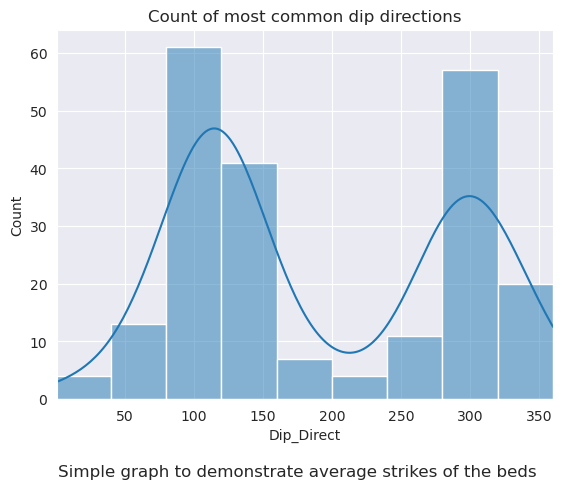

In [55]:

directions = sns.histplot(data=WV_tusc_anticline_structures["Dip_Direct"], kde=True)
plt.xlim(1,360)
plt.title("Count of most common dip directions")
'''NW/SE dipping beds'''

txt="Simple graph to demonstrate average strikes of the beds"
plt.figtext(0.5, -0.05, txt, wrap=True, horizontalalignment='center', fontsize=12)

If you don't have an azimuth

```WV_tusc_anticline_structures['Strike'] = (WV_tusc_anticline_structures['Dip_Direct'] - 90) % 360```


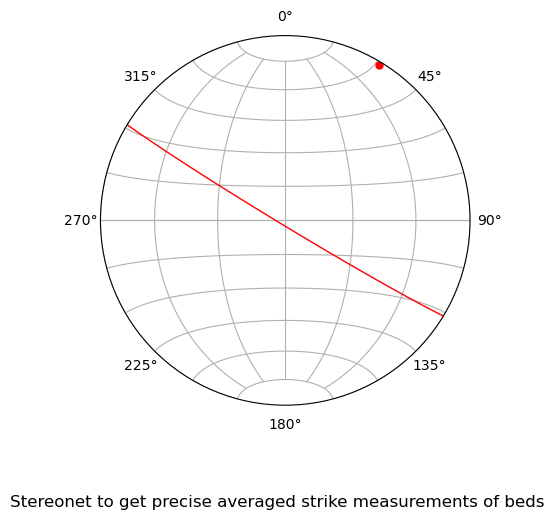

In [29]:
#this is an example plot normally fit for strikes and dips so it's labeled as such but the information i entered was for the dip directions to get some numbers
fig, ax = mplstereonet.subplots()

dip_directions = WV_tusc_anticline_structures['Dip_Direct']
dips = WV_tusc_anticline_structures['Dip_Angle']
strikes = np.array(dip_directions) - 90

#ax.pole(strikes, dips, "bo")
#ax.plane(strikes, dips, color='black', lw=1)

fit_strike, fit_dip = mplstereonet.fit_girdle(strikes, dips)

ax.plane(fit_strike, fit_dip, color='red', lw=1)
ax.pole(fit_strike, fit_dip, marker='o', color='red', markersize=5)
ax.grid(True)
txt="Stereonet to get precise averaged strike measurements of beds"
plt.figtext(0.5, -0.05, txt, wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

In [30]:
#created a column for whether or not the structure is dipping NW or SE based on stereonet

result = []
for value in WV_tusc_anticline_structures['Dip_Direct']:
    if 30 <= value <= 210:
        result.append("SE")
    else:
        result.append("NW")

WV_tusc_anticline_structures['Compass_direct'] = result


In [31]:
interlimb_dict = {}
for anticline in WV_tusc_anticline_structures['Anticline_ID'].unique():
    # print(anticline)
    slice = WV_tusc_anticline_structures.loc[WV_tusc_anticline_structures['Anticline_ID'] == anticline]
    if len(slice['Compass_direct'].unique()) == 2:
        means = slice.groupby('Compass_direct')['Dip_Angle'].mean()
        # print(means)
        interlimb_dict[str(anticline)] = 180 - (means['NW'] + means['SE'])

print(interlimb_dict)

{'18': np.float64(104.83333333333333), '21': np.float64(115.675), '27': np.float64(68.12946428571428), '23': np.float64(133.0), '30': np.float64(99.04662162162163), '34': np.float64(120.17619047619047)}


In [32]:
WV_tusc_anticline_structures['Interlimb_Angle'] = WV_tusc_anticline_structures['Anticline_ID'].astype(str).map(interlimb_dict)

In [33]:
WV_tusc_anticline_structures.loc[WV_tusc_anticline_structures['Interlimb_Angle'].notna()]

Strike  Dip_Angle  Symbol  Dip_Direct                          geometry  \
62       219         23       1         309  POINT (-8845377.101 4651734.996)   
55       208         39       1         298  POINT (-8844277.313 4653018.375)   
50       213         21       1         303  POINT (-8843973.859 4653889.605)   
38        31         44       1         121  POINT (-8842959.815 4654633.404)   
34        28         51       1         118  POINT (-8842594.034 4655381.193)   
...      ...        ...     ...         ...                               ...   
3435     230         38       1         320  POINT (-8711862.621 4811066.795)   
3433     232         18       1         322  POINT (-8711577.611 4811332.019)   
3434     229         35       1         319   POINT (-8711685.71 4811375.858)   
3554     241         27       1         331  POINT (-8711641.591 4811534.464)   
91       204         25       1         294  POINT (-8711430.889 4811713.825)   

     Station       long        lat  Anticline_ID Latitude_Bins Compass_direct  \
62        63 -79.435583  38.501574            18  (38.5, 39.0]             NW   
55        56 -79.435583  38.501574            18  (38.5, 39.0]             NW   
50        51 -79.435583  38.501574            18  (38.5, 39.0]             NW   
38        39 -79.435583  38.501574            18  (38.5, 39.0]             SE   
34        35 -79.435583  38.501574            18  (38.5, 39.0]             SE   
...      ...        ...        ...           ...           ...            ...   
3435     NaN -78.271110  39.596404            34  (39.5, 40.0]             NW   
3433     NaN -78.271110  39.596404            34  (39.5, 40.0]             NW   
3434     NaN -78.271110  39.596404            34  (39.5, 40.0]             NW   
3554     NaN -78.271110  39.596404            34  (39.5, 40.0]             NW   
91       NaN -78.271110  39.596404            34  (39.5, 40.0]             NW   

      Interlimb_Angle  
62         104.833333  
55         104.833333  
50         104.833333  
38         104.833333  
34         104.833333  
...               ...  
3435       120.176190  
3433       120.176190  
3434       120.176190  
3554       120.176190  
91         120.176190  

[214 rows x 12 columns]

## WV Data Visualization (playing around)


Text(0.5, -0.1, 'Simple graph to demonstrate West VA dip angles')

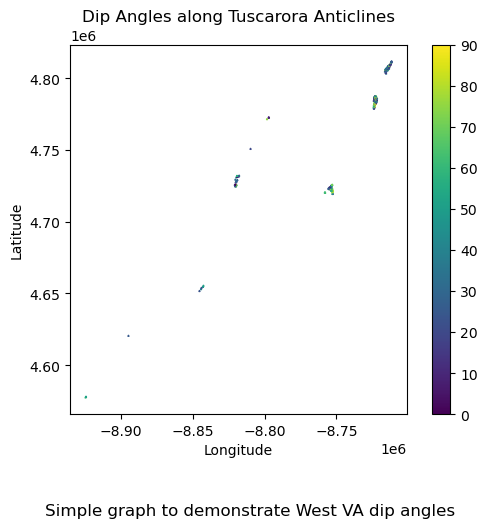

In [ ]:
fig,ax = plt.subplots()
wvast = WV_tusc_anticline_structures.plot('Dip_Angle', c='Dip_Angle', s=0.5, marker='^', ax=ax, legend=True)
ax.set_title('Dip Angles along Tuscarora Anticlines')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

#this is the correct coordinate system, the axes are just reading the other column

txt="Simple graph to demonstrate West VA dip angles"
plt.figtext(0.5, -0.05, txt, wrap=True, horizontalalignment='center', fontsize=12)

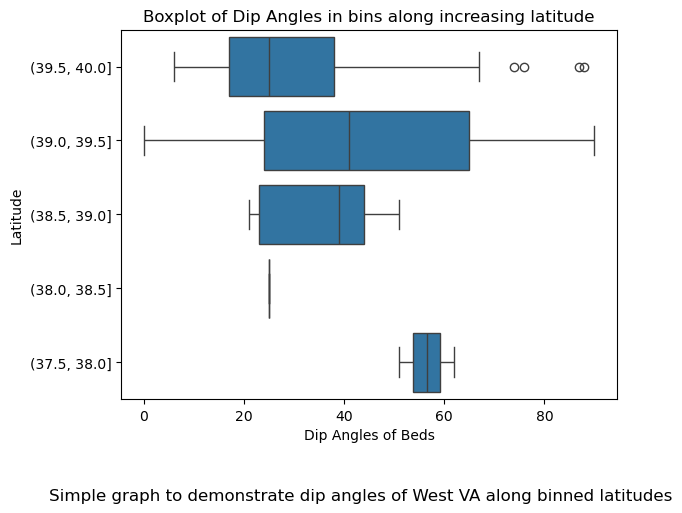

In [ ]:
fig,ax = plt.subplots()
#sns.displot(data=WV_tusc_anticline_structures, x='Dip_Angle', y='lat')
k = sns.boxplot(y=WV_tusc_anticline_structures['Latitude_Bins'], x=WV_tusc_anticline_structures['Dip_Angle'],orient='h', ax=ax)
ax.invert_yaxis()
ax.set_title('Boxplot of Dip Angles in bins along increasing latitude')
ax.set_ylabel('Latitude')
ax.set_xlabel('Dip Angles of Beds')

txt="Simple graph to demonstrate dip angles of West VA along binned latitudes"
plt.figtext(0.5, -0.05, txt, wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

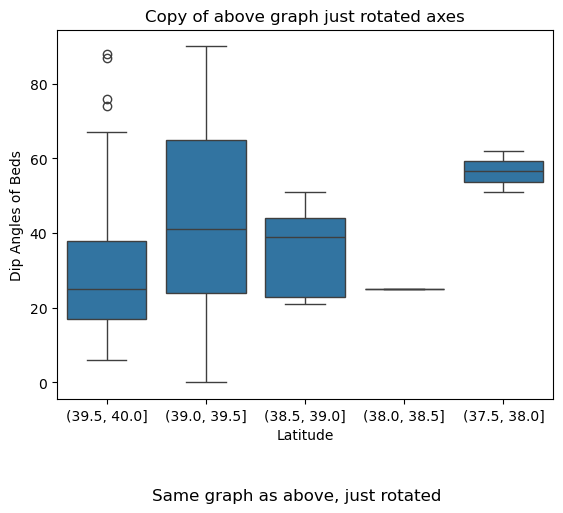

In [ ]:
fig,ax = plt.subplots()
#sns.displot(data=WV_tusc_anticline_structures, x='Dip_Angle', y='lat')
kms = sns.boxplot(x=WV_tusc_anticline_structures['Latitude_Bins'], y=WV_tusc_anticline_structures['Dip_Angle'], ax=ax)
ax.invert_xaxis()
ax.set_title('Copy of above graph just rotated axes')
ax.set_xlabel('Latitude')
ax.set_ylabel('Dip Angles of Beds')


txt="Same graph as above, just rotated"
plt.figtext(0.5, -0.05, txt, wrap=True, horizontalalignment='center', fontsize=12)

plt.show()

Text(0.5, -0.1, 'Same graph as above, just a reg plot')

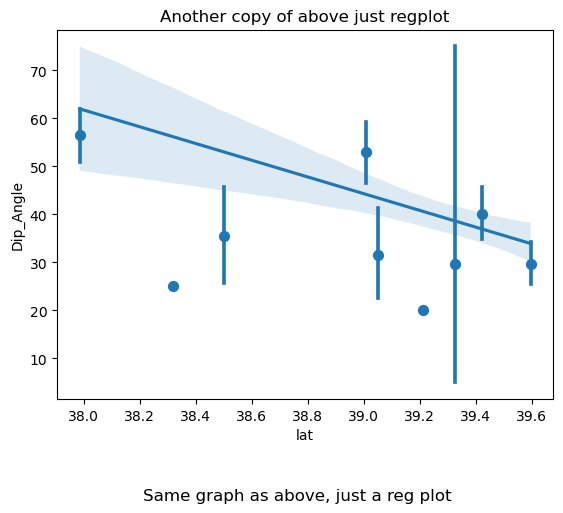

In [ ]:
sns.regplot(data=WV_tusc_anticline_structures, x="lat", y="Dip_Angle", x_estimator=np.mean, order=1)
plt.title("Another copy of above just regplot")

txt="Same graph as above, just a reg plot"
plt.figtext(0.5, -0.05, txt, wrap=True, horizontalalignment='center', fontsize=12)


## Methodology

Brief explanation of this plot:
    
I will name this plot _The West Virginia Method_.

Along the way, we have created multiple shapefiles; each with their own extent of data. As we continued, we clipped, buffered, overlayed, and intersected these dataframes onto one another to end up with the values and their corresponding plots above. To represent this journey, I've created two plots below: one of which is the polygons and linestrings and the other which is the coordinate controls (all states), the West Virginia points, and then the West Virginia Anticline-specific Structures.

I am sticking to my methodology in West Virginia because it was the most time-consuming of the data collection as the other three states were collected by hand and had more leniency in that.

I will explain this further so you don't have the scroll up:

(Each are in chronological order)
* _ant_ = West Virginia anticline linestrings; plot 1
    * what was done to _ant_ was a 1/2 mile buffer along the linestrings to create a polygon able to be joined to other shapefiles
* _points_ = All appalachian control points; plot 2
    * This is all points cut down to fit West Virginia statistically but the plot does not know that
* _tuscpo_ = Tuscarora formation polygons; plot 1
    * This is the formation specific polygons. No structural components to it, it is just for joining purposes.
* _tuscat_ = Tuscarora formation (tuscpo) clipped to anticlines (ants); plot 1
    * This is a polygon clip meaning that the original anticline linestring would not have functioned properly or given any useable data. 
* _wvstu_ = All structural data within the chosen West Virginia counties; plot 2
    * counties were hand-picked from the West Virginia public databases which are downloaded, extracted, and imported into the server here before being used
* _wpoints_ = Structural data points joined to control points; plot 2 
    * 3 mile radius of structural points surrounding the control points within West Virginia
* _struct_ = All of the above; plot 2 and above plots (including the plot with basemap)
    * All of the above geometry joined/clipped together to have specifically anticline structures in the tuscarora. This started as around 16k structures (or more depending on if you count the polygons) and were leveled down to 500

/local/scr/kmshefelton/TMPDIR/ipykernel_382590/1967436306.py:38: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax1.legend(loc='upper left')
/local/scr/kmshefelton/TMPDIR/ipykernel_382590/1967436306.py:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend(loc='upper left')


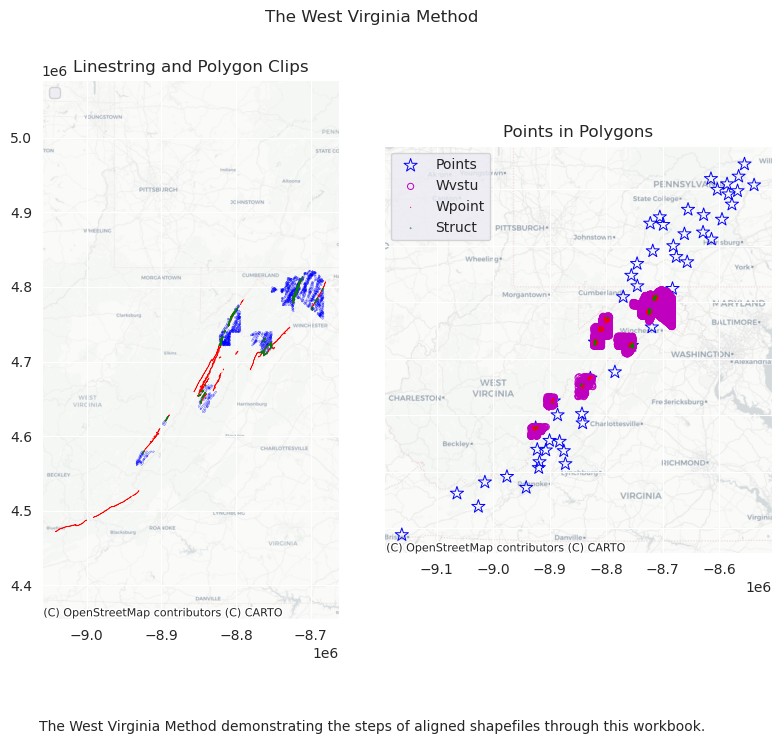

In [54]:
ant=ants['geometry']
a = gpd.GeoSeries(ant)

points = coord['geometry']
p=gpd.GeoSeries(points)

tuscpo = tuscarora['geometry']
t=gpd.GeoSeries(tuscpo)

tuscat = Tusc_anticlines['geometry']
ta=gpd.GeoSeries(tuscat)

wvstu = wvs['geometry']
ws = gpd.GeoSeries(wvstu)

wpoint = WestVA['geometry']
wvp = gpd.GeoSeries(wpoint)

struct = WV_tusc_anticline_structures['geometry']
wvpt = gpd.GeoSeries(struct)

fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(10,7))
fig.suptitle('The West Virginia Method')
ax1.set_title('Linestring and Polygon Clips')
ax2.set_title('Points in Polygons')
plt.subplots_adjust(wspace=0)


a.plot(ax=ax1, facecolor="none", edgecolor='b', lw=0.2, label='Ant')
p.plot(ax=ax2, marker = '*', markersize=100,facecolor="none", edgecolor='b', lw=0.7, label='Points' )
t.plot(ax=ax1, facecolor="none", edgecolor='r', lw=0.5, label='Tuscpo' )
ta.plot(ax=ax1, facecolor="none", edgecolor='g', lw=0.7, label='Tuscat' )
ws.plot(ax=ax2, markersize=20,facecolor="none", edgecolor='m', lw=0.7, label='Wvstu' )
wvp.plot(ax=ax2, markersize=0.1, facecolor="none", edgecolor='r', lw=0.5, label='Wpoint' )
wvpt.plot(ax=ax2,markersize=0.1, facecolor="none", edgecolor='g', lw=0.9, label='Struct' )


ax1.legend(loc='upper left')
ax2.legend(loc='upper left')
cx.add_basemap(ax=ax2,crs=coord.crs, source=cx.providers.CartoDB.Positron)
cx.add_basemap(ax=ax1,crs= tuscarora.crs, source=cx.providers.CartoDB.Positron)



txt="The West Virginia Method demonstrating the steps of aligning shapefiles through this workbook."
plt.figtext(0.5, -0.01, txt, wrap=True, horizontalalignment='center', fontsize=10)
plt.show()

## Export Dataframe

In [68]:

csvpath = Path('/sciclone/home/kmshefelton/REMODEL/APPD/Structures_WV.csv')  
csvpath.parent.mkdir(parents=True, exist_ok=True)  
WV_tusc_anticline_structures.to_csv(csvpath)


## State files

### Download

PA, VA, and MD were collected via ArcGIS by downloading individual collected maps published within the past hundred years, coordinated to arcGIS, and drawn over by manual entry to create csv files of structures and interlimb angles. This was a long process but created very precise files without having to sift through large dataframes. 
For an example, here is an image demonstrating how to collect interlimb angles via using a measuring tool from a cross-section (instead of calculating from averaged slopes).
![GIS Screenshot.png](<attachment:GIS Screenshot.png>)
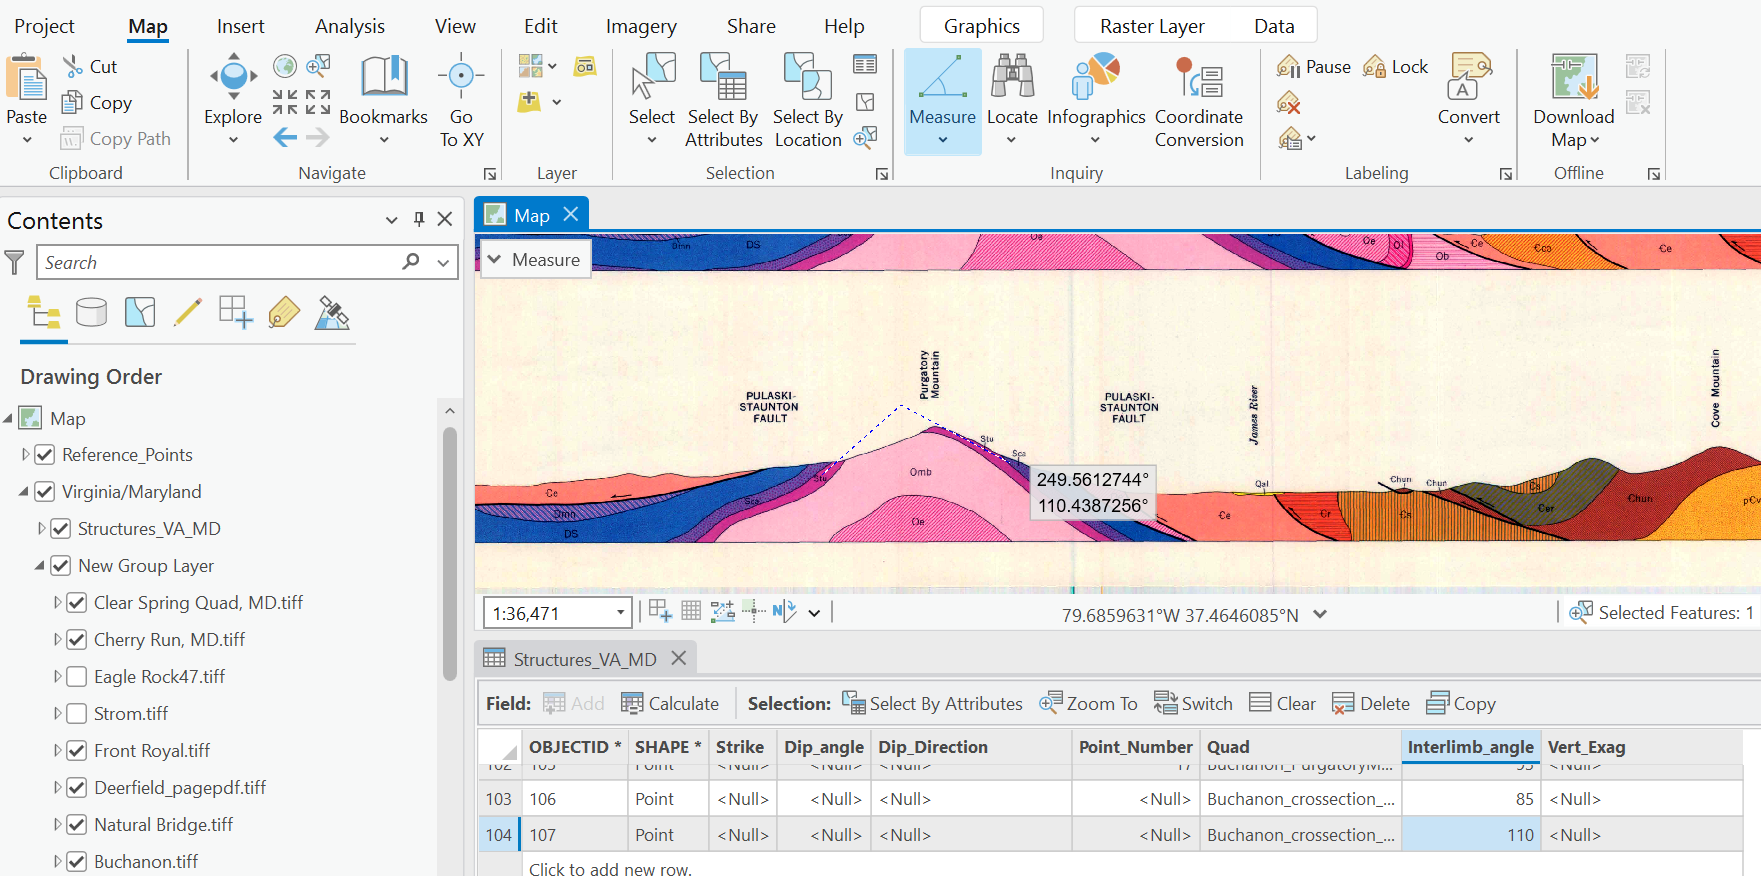

In [39]:
pathPA = Path('/sciclone/home/kmshefelton/REMODEL/APPD/CSVs/Structures_PA_ExportTable.csv')
PA = pd.read_csv(pathPA)

pathVAMD = Path('/sciclone/home/kmshefelton/REMODEL/APPD/CSVs/Structures_VA_MD.csv')
VAMD = pd.read_csv(pathVAMD)

pathWV = Path('/sciclone/home/kmshefelton/REMODEL/APPD/CSVs/Structures_WV.csv')
WV = pd.read_csv(pathWV)

### Match the columns and combine

In [40]:
PA[['long', 'lat']] = PA['Geometry'].str.split(" ", expand=True)
VAMD[['long', 'lat']] = VAMD['Geometry'].str.split(" ", expand=True)

all_data = pd.concat([PA, VAMD, WV], ignore_index=True)

all_data['Point_Number'] =all_data['Point_Number'].fillna(value=9999)
all_data['Point_Number'] = all_data['Point_Number'].astype(int)
all_data['lat'] = all_data['lat'].astype(float)
all_data['IA']= all_data['Interlimb_Angle'].combine_first(all_data['Interlimb_angle'])

In [41]:
# all_data['IA'].value_counts()

### Create dataframe and align geometry

In [42]:
All_State_Structures= gpd.GeoDataFrame(
    all_data.loc[all_data['long'].notna()], # what dataframe are we using?
    geometry=gpd.points_from_xy(
        all_data.loc[all_data['long'].notna()]['long'], all_data.loc[all_data['long'].notna()]['lat']), # here we specify which columns have the long and lat
          crs='epsg:4326' # finally end specifying the WGS84 spatial reference
          ) 

In [43]:
All_State_Structures

Point_Number                   Geometry                      Quad  \
0              55  -076.96825355 41.30834530                Muncy/Mont   
1              55  -076.96350493 41.30816171                Muncy/Mont   
2              55  -076.95817155 41.30823901                Muncy/Mont   
3              55  -077.00468325 41.27194296                Muncy/Mont   
4              55  -076.95817155 41.30823901  M_M_crosssection_nittany   
..            ...                        ...                       ...   
480          9999                        NaN                       NaN   
481          9999                        NaN                       NaN   
482          9999                        NaN                       NaN   
483          9999                        NaN                       NaN   
484          9999                        NaN                       NaN   

     Strike  Dip_Angle Dip_Direct  Interlimb_angle  Vert_Exag           long  \
0     258.0       22.0         NW              NaN        NaN  -076.96825355   
1     277.0       15.0         NE              NaN        NaN  -076.96350493   
2     312.0       25.0         NE              NaN        NaN  -076.95817155   
3      88.0       26.0         SE            132.0        NaN  -077.00468325   
4       NaN        NaN        NaN            112.0        NaN  -076.95817155   
..      ...        ...        ...              ...        ...            ...   
480   230.0       38.0        320              NaN        NaN      -78.27111   
481   232.0       18.0        322              NaN        NaN      -78.27111   
482   229.0       35.0        319              NaN        NaN      -78.27111   
483   241.0       27.0        331              NaN        NaN      -78.27111   
484   204.0       25.0        294              NaN        NaN      -78.27111   

           lat  Unnamed: 0  Symbol                    geometry Station  \
0    41.308345         NaN     NaN  POINT (-76.96825 41.30835)     NaN   
1    41.308162         NaN     NaN   POINT (-76.9635 41.30816)     NaN   
2    41.308239         NaN     NaN  POINT (-76.95817 41.30824)     NaN   
3    41.271943         NaN     NaN  POINT (-77.00468 41.27194)     NaN   
4    41.308239         NaN     NaN  POINT (-76.95817 41.30824)     NaN   
..         ...         ...     ...                         ...     ...   
480  39.596404      3435.0     1.0   POINT (-78.27111 39.5964)     NaN   
481  39.596404      3433.0     1.0   POINT (-78.27111 39.5964)     NaN   
482  39.596404      3434.0     1.0   POINT (-78.27111 39.5964)     NaN   
483  39.596404      3554.0     1.0   POINT (-78.27111 39.5964)     NaN   
484  39.596404        91.0     1.0   POINT (-78.27111 39.5964)     NaN   

     Anticline_ID Latitude_Bins Compass_direct  Interlimb_Angle          IA  
0             NaN           NaN            NaN              NaN         NaN  
1             NaN           NaN            NaN              NaN         NaN  
2             NaN           NaN            NaN              NaN         NaN  
3             NaN           NaN            NaN              NaN  132.000000  
4             NaN           NaN            NaN              NaN  112.000000  
..            ...           ...            ...              ...         ...  
480          34.0  (39.5, 40.0]             NW       122.151478  122.151478  
481          34.0  (39.5, 40.0]             NW       122.151478  122.151478  
482          34.0  (39.5, 40.0]             NW       122.151478  122.151478  
483          34.0  (39.5, 40.0]             NW       122.151478  122.151478  
484          34.0  (39.5, 40.0]             NW       122.151478  122.151478  

[485 rows x 19 columns]

## Final State Plots

In [44]:
All_State_Structures['lat'].max(), All_State_Structures['lat'].min()

(np.float64(41.3083453), np.float64(36.99298001))

### Latitude into bins for cleaner plots

In [45]:
#more latitude bins sos
bins = np.linspace(36.5,41.5,11)
All_State_Structures['Lat_bins'] = pd.cut(All_State_Structures['lat'], bins=bins)
All_State_Structures

Point_Number                   Geometry                      Quad  \
0              55  -076.96825355 41.30834530                Muncy/Mont   
1              55  -076.96350493 41.30816171                Muncy/Mont   
2              55  -076.95817155 41.30823901                Muncy/Mont   
3              55  -077.00468325 41.27194296                Muncy/Mont   
4              55  -076.95817155 41.30823901  M_M_crosssection_nittany   
..            ...                        ...                       ...   
480          9999                        NaN                       NaN   
481          9999                        NaN                       NaN   
482          9999                        NaN                       NaN   
483          9999                        NaN                       NaN   
484          9999                        NaN                       NaN   

     Strike  Dip_Angle Dip_Direct  Interlimb_angle  Vert_Exag           long  \
0     258.0       22.0         NW              NaN        NaN  -076.96825355   
1     277.0       15.0         NE              NaN        NaN  -076.96350493   
2     312.0       25.0         NE              NaN        NaN  -076.95817155   
3      88.0       26.0         SE            132.0        NaN  -077.00468325   
4       NaN        NaN        NaN            112.0        NaN  -076.95817155   
..      ...        ...        ...              ...        ...            ...   
480   230.0       38.0        320              NaN        NaN      -78.27111   
481   232.0       18.0        322              NaN        NaN      -78.27111   
482   229.0       35.0        319              NaN        NaN      -78.27111   
483   241.0       27.0        331              NaN        NaN      -78.27111   
484   204.0       25.0        294              NaN        NaN      -78.27111   

           lat  Unnamed: 0  Symbol                    geometry Station  \
0    41.308345         NaN     NaN  POINT (-76.96825 41.30835)     NaN   
1    41.308162         NaN     NaN   POINT (-76.9635 41.30816)     NaN   
2    41.308239         NaN     NaN  POINT (-76.95817 41.30824)     NaN   
3    41.271943         NaN     NaN  POINT (-77.00468 41.27194)     NaN   
4    41.308239         NaN     NaN  POINT (-76.95817 41.30824)     NaN   
..         ...         ...     ...                         ...     ...   
480  39.596404      3435.0     1.0   POINT (-78.27111 39.5964)     NaN   
481  39.596404      3433.0     1.0   POINT (-78.27111 39.5964)     NaN   
482  39.596404      3434.0     1.0   POINT (-78.27111 39.5964)     NaN   
483  39.596404      3554.0     1.0   POINT (-78.27111 39.5964)     NaN   
484  39.596404        91.0     1.0   POINT (-78.27111 39.5964)     NaN   

     Anticline_ID Latitude_Bins Compass_direct  Interlimb_Angle          IA  \
0             NaN           NaN            NaN              NaN         NaN   
1             NaN           NaN            NaN              NaN         NaN   
2             NaN           NaN            NaN              NaN         NaN   
3             NaN           NaN            NaN              NaN  132.000000   
4             NaN           NaN            NaN              NaN  112.000000   
..            ...           ...            ...              ...         ...   
480          34.0  (39.5, 40.0]             NW       122.151478  122.151478   
481          34.0  (39.5, 40.0]             NW       122.151478  122.151478   
482          34.0  (39.5, 40.0]             NW       122.151478  122.151478   
483          34.0  (39.5, 40.0]             NW       122.151478  122.151478   
484          34.0  (39.5, 40.0]             NW       122.151478  122.151478   

         Lat_bins  
0    (41.0, 41.5]  
1    (41.0, 41.5]  
2    (41.0, 41.5]  
3    (41.0, 41.5]  
4    (41.0, 41.5]  
..            ...  
480  (39.5, 40.0]  
481  (39.5, 40.0]  
482  (39.5, 40.0]  
483  (39.5, 40.0]  
484  (39.5, 40.0]  

[485 rows x 20 columns]

### CSV of the combined states

In [33]:
csvfull = Path('/sciclone/home/kmshefelton/REMODEL/APPD/All_State_Structures.csv')  
csvfull.parent.mkdir(parents=True, exist_ok=True)  
All_State_Structures.to_csv(csvfull)

### Plots

#### Stats

Text(0.5, -0.1, 'Simple graph to show the structural measurements along all states.')

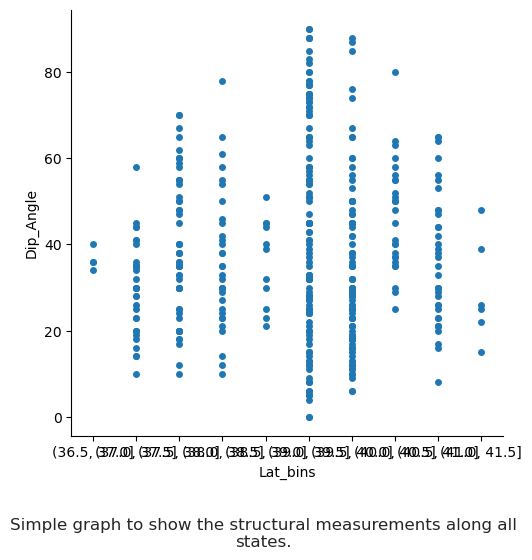

In [ ]:
ax=sns.catplot(data=All_State_Structures, x='Lat_bins',y='Dip_Angle', jitter=False)
sns.set_style("darkgrid")


txt="Simple graph to show the structural measurements along all states."
plt.figtext(0.5, -0.1, txt, wrap=True, horizontalalignment='center', fontsize=10)

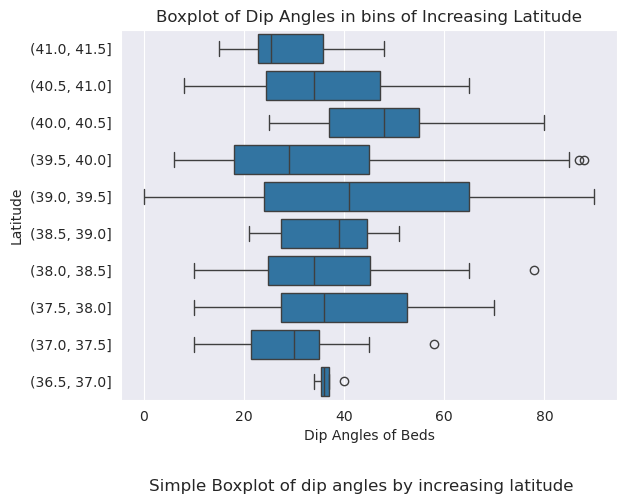

In [53]:
fig,ax = plt.subplots()
#sns.displot(data=WV_tusc_anticline_structures, x='Dip_Angle', y='lat')
k = sns.boxplot(y=All_State_Structures['Lat_bins'], x=All_State_Structures['Dip_Angle'],orient='h', ax=ax)
ax.invert_yaxis()
ax.set_title('Boxplot of Dip Angles in bins of Increasing Latitude')
ax.set_ylabel('Latitude')
ax.set_xlabel('Dip Angles of Beds')


txt="Simple Boxplot of dip angles by increasing latitude"
plt.figtext(0.5, -0.08, txt, wrap=True, horizontalalignment='center', fontsize=12)

plt.show()

/local/scr/kmshefelton/TMPDIR/ipykernel_382590/1140299428.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([36.5,37,37.5,38,38.5,39,39.5,40,40.5,41,41.5])
/local/scr/kmshefelton/TMPDIR/ipykernel_382590/1140299428.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=All_State_Structures['Lat_bins'], x=All_State_Structures['Dip_Angle'],orient='h', width=0.5, ax=ax1, palette="GnBu_d").set(xlabel='Dip Angle of Beds', ylabel='Latitude')
/local/scr/kmshefelton/TMPDIR/ipykernel_382590/1140299428.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=All_State_Structures['Lat_bins'], x=All_

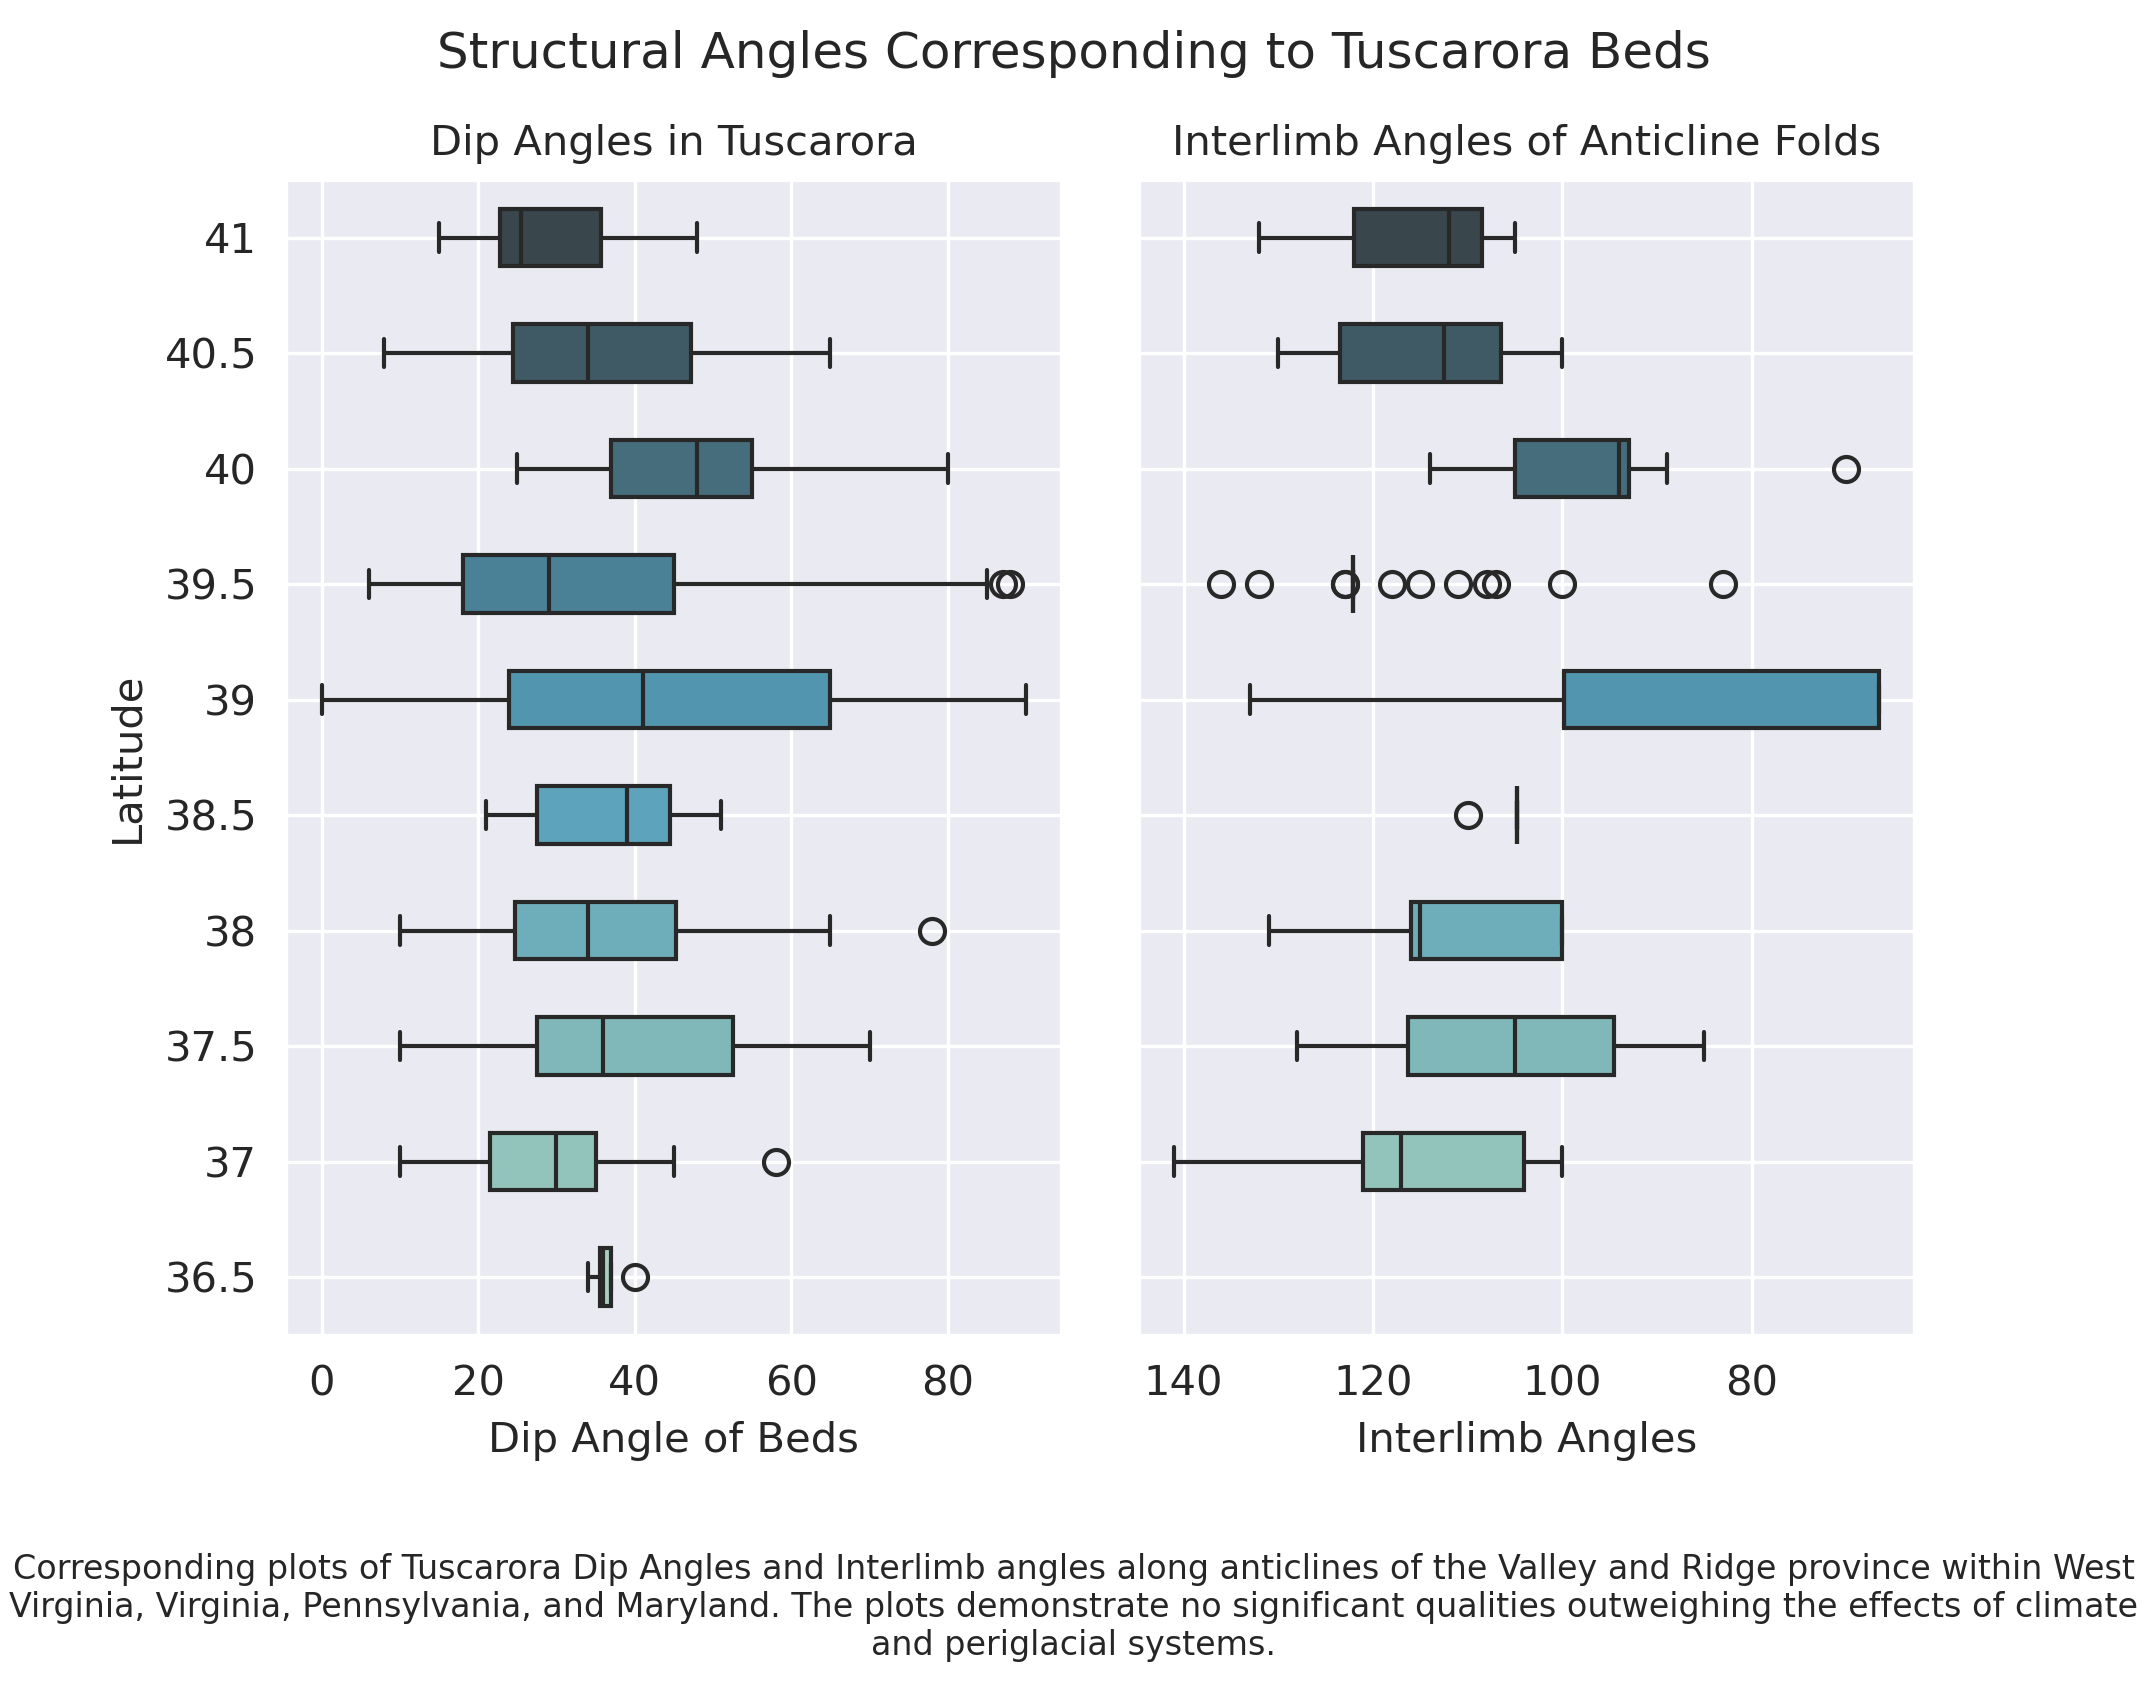

In [51]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(7, 5), sharey=True, dpi=300)
fig.suptitle('Structural Angles Corresponding to Tuscarora Beds')
ax1.set_title('Dip Angles in Tuscarora', fontsize=10)
ax2.set_title('Interlimb Angles of Anticline Folds', fontsize=10)
plt.gca().set_ylabel(None)
plt.gca().invert_xaxis()
plt.subplots_adjust(wspace=0.1)

ax1.set_yticklabels([36.5,37,37.5,38,38.5,39,39.5,40,40.5,41,41.5])

ax2.grid(True)

sns.boxplot(y=All_State_Structures['Lat_bins'], x=All_State_Structures['Dip_Angle'],orient='h', width=0.5, ax=ax1, palette="GnBu_d").set(xlabel='Dip Angle of Beds', ylabel='Latitude')
ax1.grid(True)
plt.grid()
sns.boxplot(y=All_State_Structures['Lat_bins'], x=All_State_Structures['IA'],orient='h', width=0.5, palette="GnBu_d").set(xlabel='Interlimb Angles')
plt.grid()

plt.gca().invert_yaxis()


txt="Corresponding plots of Tuscarora Dip Angles and Interlimb angles along anticlines of the Valley and Ridge province within West Virginia, Virginia, Pennsylvania, and Maryland. The plots demonstrate no significant qualities outweighing the effects of climate and periglacial systems."
plt.figtext(0.5, -0.1, txt, wrap=True, horizontalalignment='center', fontsize=8)

plt.show()

#### Geolocated points with basemap

Text(0.5, -0.1, 'Tuscarora Structural Measurements plotted along the Valley and Ridge province of West Virginia, Virginia, Maryland, and Pennsylvania.')

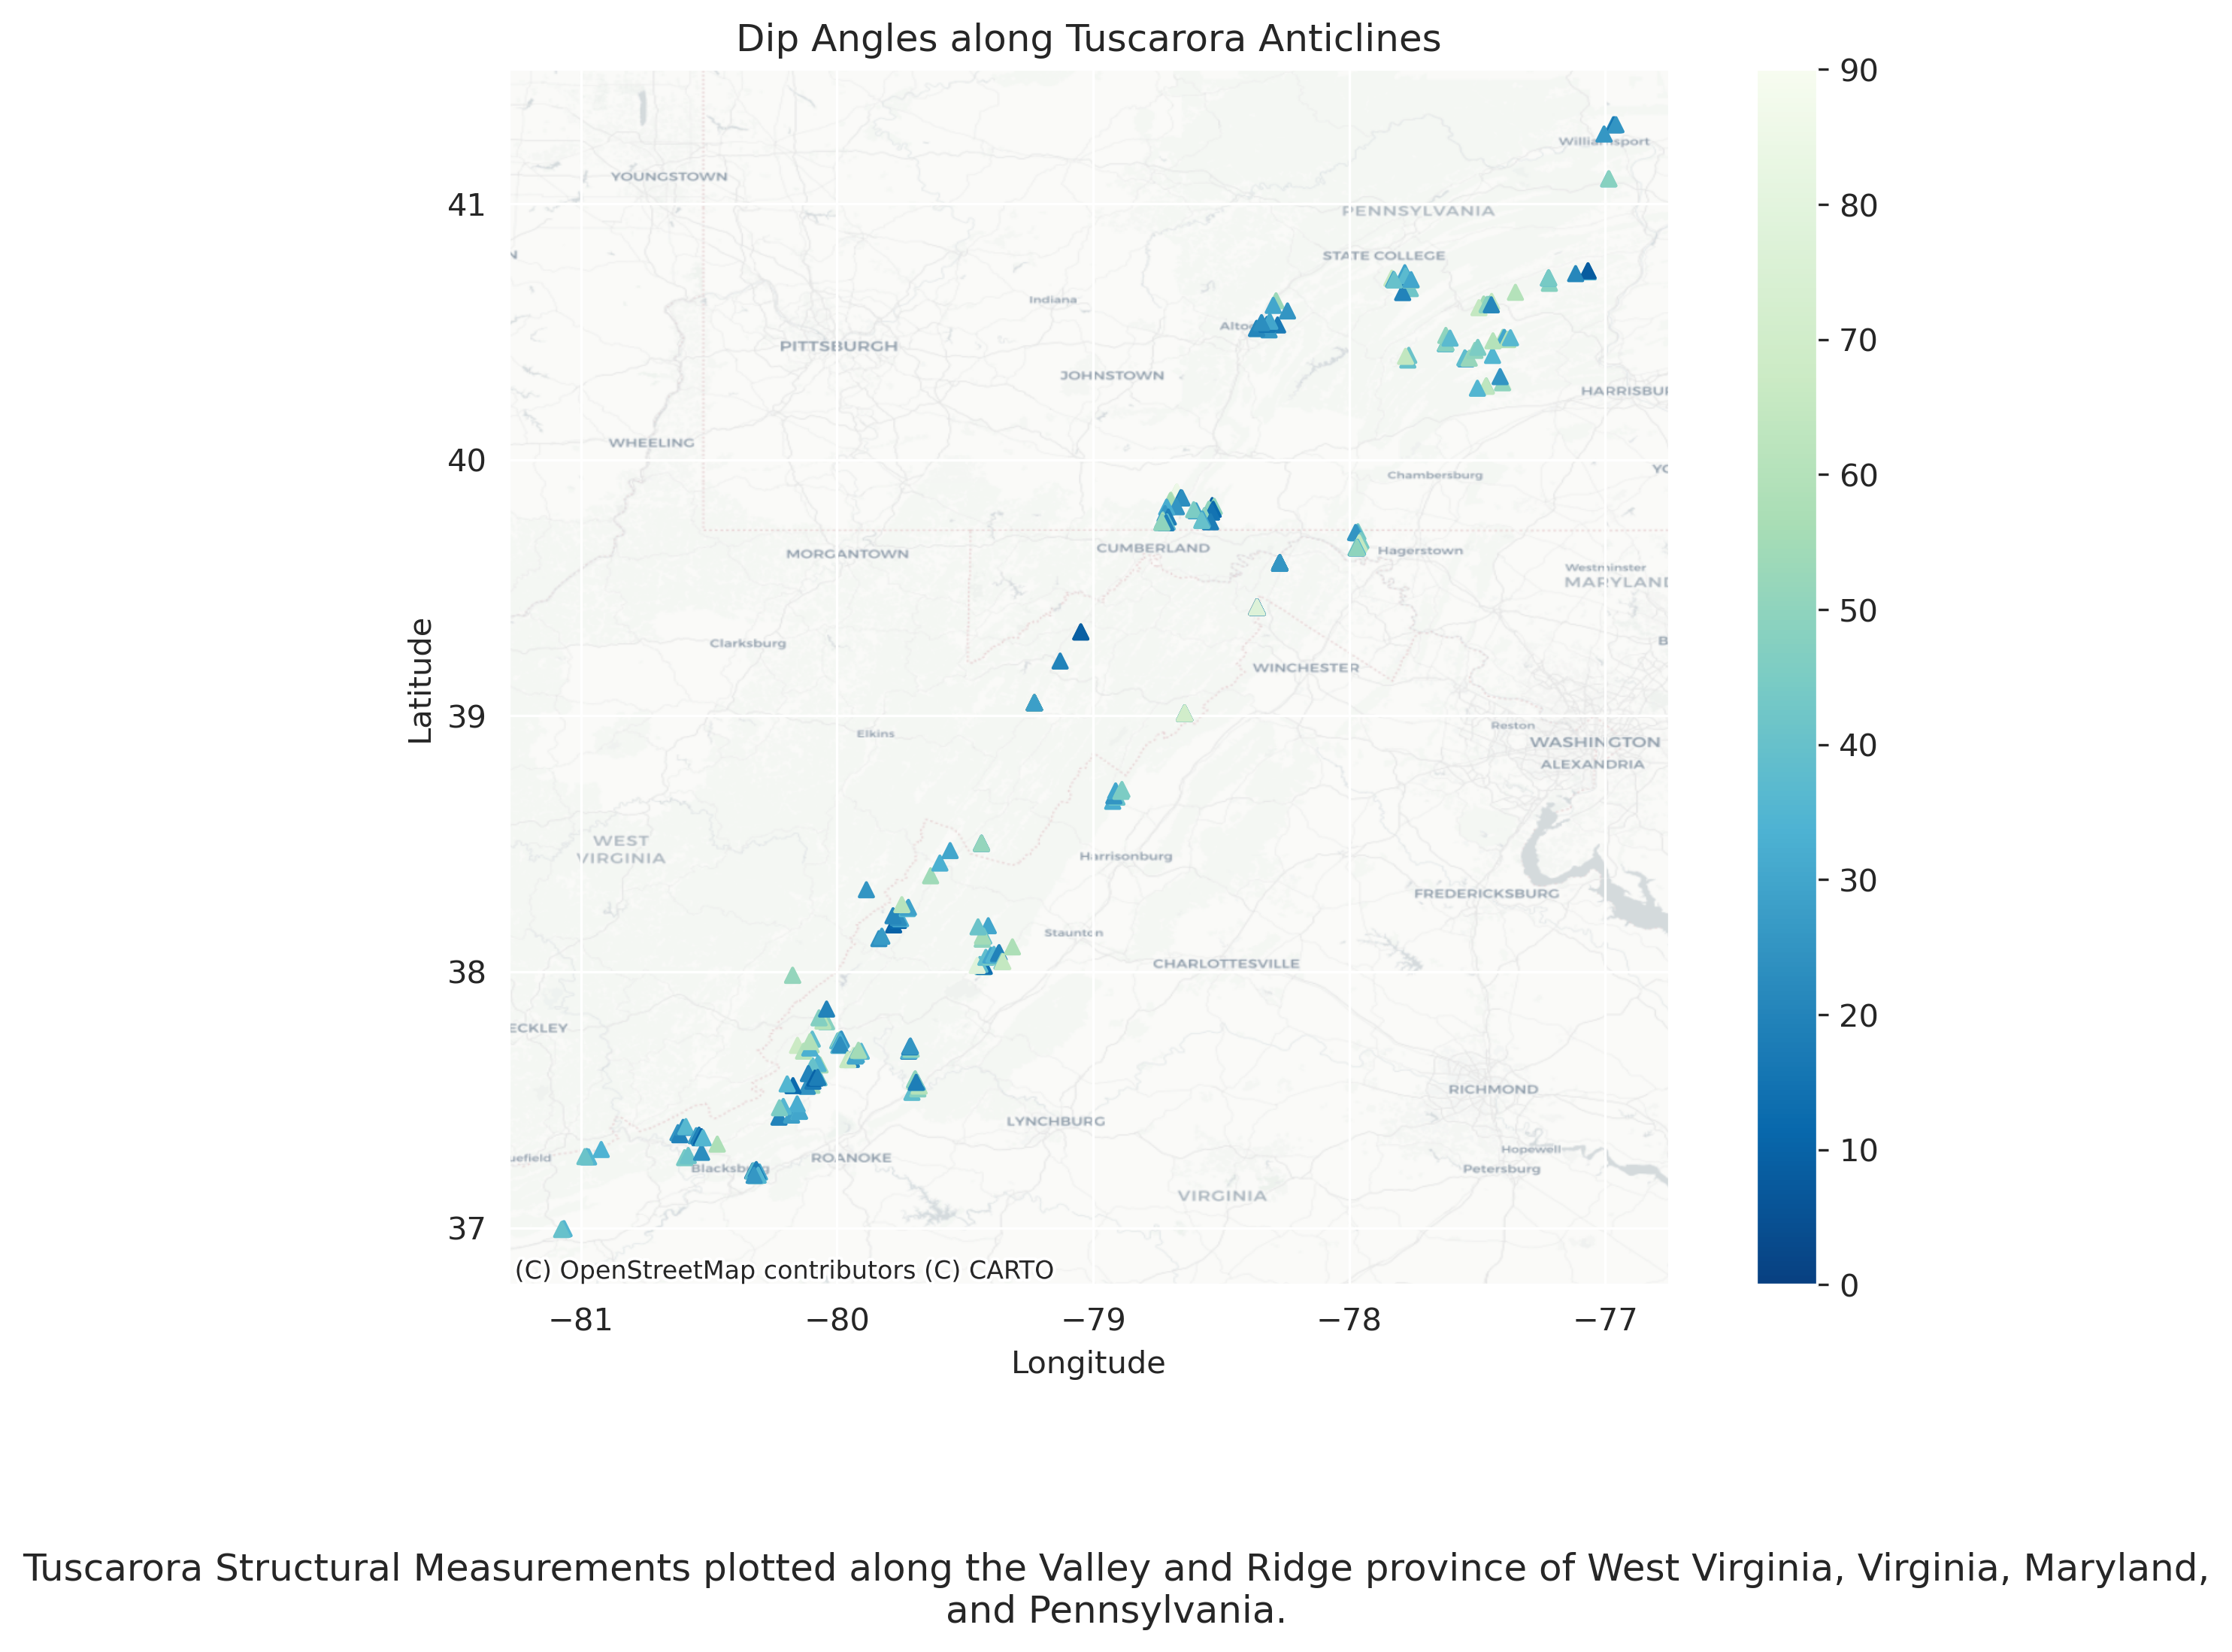

In [ ]:
fig,ax = plt.subplots(figsize=(10,7),dpi=300)
stru = All_State_Structures.plot('Dip_Angle', c='Dip_Angle', s=20, marker='^', cmap="GnBu_r", ax=ax, legend=True)

cx.add_basemap(ax, crs=All_State_Structures.crs, source=cx.providers.CartoDB.Positron)



ax.set_title('Dip Angles along Tuscarora Anticlines')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
#plt.savefig('structure_map.png')


txt="Tuscarora Structural Measurements plotted along the Valley and Ridge province of West Virginia, Virginia, Maryland, and Pennsylvania."
plt.figtext(0.5, -0.1, txt, wrap=True, horizontalalignment='center', fontsize=10)